# Data Preparation

In [59]:
# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

In [113]:
import os
import pandas as pd 

## Explore the data folder

The data was provided by Olist, downloaded from kaggle. 

Inspect the data structure from the schema:

![Schema](schema.png)

In [2]:
!tree

.
├── 0-Project_Setup.ipynb
├── 01-data_preparation.ipynb
├── data
│   ├── README.md
│   └── csv
│       ├── brazilian-ecommerce.zip
│       ├── olist_customers_dataset.csv
│       ├── olist_geolocation_dataset.csv
│       ├── olist_order_items_dataset.csv
│       ├── olist_order_payments_dataset.csv
│       ├── olist_order_reviews_dataset.csv
│       ├── olist_orders_dataset.csv
│       ├── olist_products_dataset.csv
│       ├── olist_sellers_dataset.csv
│       └── product_category_name_translation.csv
├── pkg
│   └── __init__.py
└── schema.png

3 directories, 15 files


## Construct the dictionary `data`

In [24]:
csv_path = os.path.join(os.getcwd(), 'data', 'csv')

file_names = [f for f in os.listdir(csv_path) if f.endswith(".csv")]

key_names = [
    name.replace("olist_", "")
    .replace(".csv", "")
    .replace("_dataset", "")
    for name in file_names
]

values = [pd.read_csv(path) for path in [os.path.join(csv_path,file_name) for file_name in file_names]]

data = {key:value for (key, value) in zip(key_names, values)}

In [61]:
## test .py script

from pkg.data import Data

data = Data().get_data()

data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

# EDA

## EDA with pandas profiling

In [64]:
import pandas_profiling


datasets_to_profile = ['sellers', 'orders', 
                      'order_items', 'customers',
                      'geolocation',
                      'order_payments',
                      'order_reviews',
                      'products']

for d in datasets_to_profile:
    print('Exporting: ', d)
    profile = data[d].profile_report(title="pd-" + d)
    profile.to_file(output_file="data/reports/" + d + ".html")

import IPython
IPython.display.HTML(filename = 'data/reports/sellers.html')

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

## EDA with sweetviz

In [73]:
import sweetviz as sv 
sv.config_parser.read("Override.ini")

for d in datasets_to_profile:
    print('Exporting: ', d)
    profile = sv.analyze(data[d])
    profile.show_html(
        filepath="data/reports/" + d + "-sv.html",
        layout = 'widescreen',
        open_browser = False)

['Override.ini']

# Metric Design

In [12]:
#load modules
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('seaborn-white')

In [9]:
print(data.keys())

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])


## Orders vs. Reviews?

---
❓Plot a histogram of `review_score`. How many valid reviews do we have in total?

In [91]:
reviews = data['order_reviews'].copy()
orders = data['orders'].copy()

print(reviews.info())
print("===" * 20)
print(reviews['review_score'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64


<AxesSubplot:xlabel='review_score', ylabel='count'>

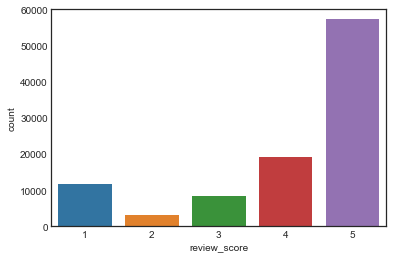

In [22]:
sns.countplot(x = reviews['review_score'])

In [44]:
print("Different order in dataset: ", orders['order_id'].nunique())
print("Different order in review table: ", reviews['order_id'].nunique())
print("Different review: ", reviews['review_id'].nunique())

print("The Order with more than one review: ", sum(reviews['order_id'].duplicated()))

print("The number of review assigned to multiple orders: ", sum(reviews['review_id'].duplicated()))
      

Different order in dataset:  99441
Different order in review table:  99441
Different review:  99173
The Order with more than one review:  559
The number of review assigned to multiple orders:  827


In [57]:
# Check if each order has a review
orders.merge(reviews, on = "order_id", how = "outer").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       100000 non-null  object
 1   customer_id                    100000 non-null  object
 2   order_status                   100000 non-null  object
 3   order_purchase_timestamp       100000 non-null  object
 4   order_approved_at              99839 non-null   object
 5   order_delivered_carrier_date   98207 non-null   object
 6   order_delivered_customer_date  97013 non-null   object
 7   order_estimated_delivery_date  100000 non-null  object
 8   review_id                      100000 non-null  object
 9   review_score                   100000 non-null  int64 
 10  review_comment_title           11715 non-null   object
 11  review_comment_message         41753 non-null   object
 12  review_creation_date           100000 non-nul

> ❗Conclusions:
> 1. Every order has a review ID and score.
> 2. Reveiws and Orders forms many-to-many relations:
    >  1. One order can have multiple review.    
    >  2. One review can be sumbitted to different orders.

---
❓Plot a histogram of `order_status`

In [46]:

print(orders.info())

print(orders['order_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


<AxesSubplot:xlabel='order_status', ylabel='count'>

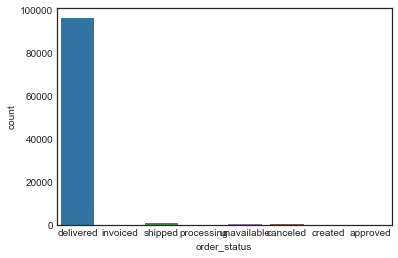

In [50]:
sns.countplot(x=orders['order_status'])

## Key Business Metrics

- Design several metrics to evaluate the business health.

### Metric one: Order Volumn

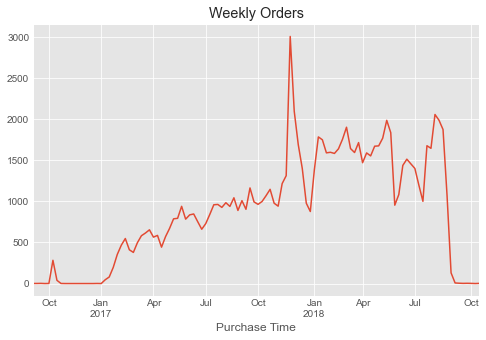

In [125]:
## Convert purshase time to datetime64

orders = data['orders'].copy()

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders_time = orders[['order_id', 'order_purchase_timestamp']].set_index('order_purchase_timestamp')

orders_time.sort_index(inplace = True)

## plot with pyplot
plt.style.use('ggplot')
plt.figure(figsize = (8, 5))
plt.title('Weekly Orders')
orders_time.resample('W').count()['order_id'].plot()
plt.xlabel("Purchase Time")
plt.show()

In [167]:
def plot_weekly_orders(status, df, x, y):
    fig = px.line(df, x = x, y = y, title = f"Weekly Orders({status})",
                 hover_name = y,
                 labels = {
                     x.name: "Time",
                     y: "Volumn"
                 })
    fig.update_layout(xaxis = dict(
                    tickmode = "linear",
                    dtick = "M3"
    ))
    fig.show()

In [169]:
total = pd.DataFrame(orders_time.resample('W').count()['order_id'])
plot_weekly_orders("Total", total, x=total.index, y="order_id")

In [179]:
undelivered_orders = orders[orders['order_status'] != "delivered"].set_index('order_purchase_timestamp')[['order_id']]
undelivered_orders = undelivered_orders.resample('W').count()

plot_weekly_orders("Non-delivered", undelivered_orders, x = undelivered_orders.index,
                  y = 'order_id')

### Metric two: Total Payment 

In [181]:
payments = data['order_payments'].copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [186]:
payments = payments.groupby(by = 'order_id').sum()['payment_value']

In [205]:
orders_payment = orders.merge(payments, on = ['order_id'], how = "left")[['order_id', 'order_purchase_timestamp','payment_value']]

In [206]:
# fill na in the column payment_values
orders_payment = orders_payment.fillna(0)

In [209]:
orders_payment = orders_payment.set_index("order_purchase_timestamp")

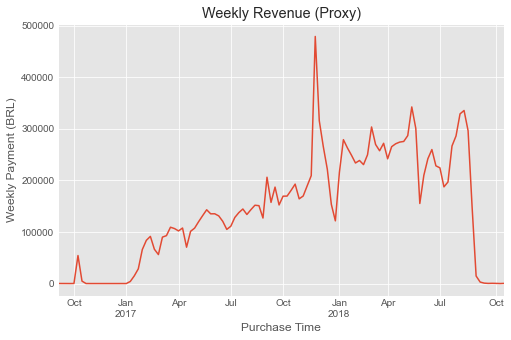

In [213]:
weekly_revenue = orders_payment.resample("W").sum()['payment_value']
plt.figure(figsize = (8, 5))
plt.title('Weekly Revenue (Proxy)')
weekly_revenue.plot()
plt.xlabel("Purchase Time")
plt.ylabel("Weekly Payment (BRL)")
plt.show()

### Metric three: Customer Satisfaction

In [235]:
# calculate the review score of each order
review_order = reviews.groupby(by = "order_id").mean()['review_score']

# add purchase time column to review_order table
review_time = orders.join(review_order, on = "order_id", how = "outer")[['order_id', 
                                                          'order_purchase_timestamp',
                                                          'review_score']]

review_time.set_index('order_purchase_timestamp', inplace = True)
review_time.sort_index(inplace = True)

In [261]:
# filter out the month where the volumn order less than 100
mask = review_time.resample("M").count()['order_id'] >= 100
monthly_review = review_time.resample("M").mean().dropna()[mask]

<ipython-input-261-77a74ce40745>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<Figure size 576x360 with 0 Axes>

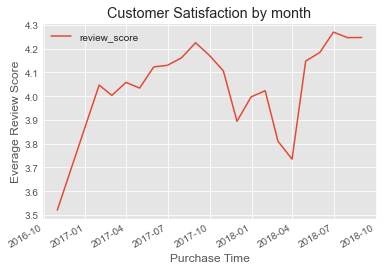

In [267]:
plt.figure(figsize = (8, 5))
monthly_review.plot()
plt.title('Customer Satisfaction by month')
plt.xlabel("Purchase Time")
plt.ylabel("Everage Review Score")
plt.show()


### Metric four: Shipping Delay

<ipython-input-314-16df3f1cf421>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-314-16df3f1cf421>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-314-16df3f1cf421>:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Text(0, 0.5, 'Days')

<Figure size 800x500 with 0 Axes>

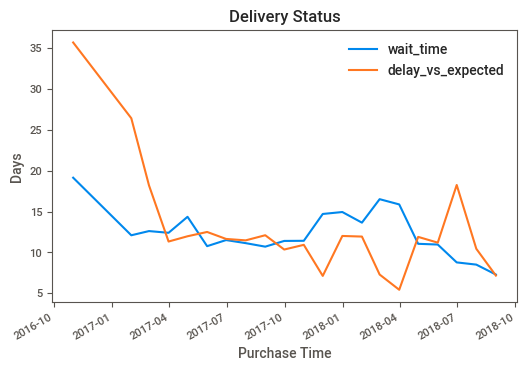

In [314]:
## only look at orders have been delivered
delivered_orders = orders[orders['order_status'] == "delivered"]

## caculate the waitime
delivered_orders["wait_time"] = (delivered_orders['order_delivered_customer_date']-\
 delivered_orders['order_purchase_timestamp']).dt.days

# caculate the days delay or expected
delivered_orders["delay_vs_expected"] = (
 delivered_orders['order_estimated_delivery_date'] -
delivered_orders['order_delivered_customer_date']
).dt.days

## Update the dataframe
delivered_orders = delivered_orders[['order_purchase_timestamp', 'wait_time', 'delay_vs_expected']]

# set purchase time as index
delivered_orders = delivered_orders.set_index('order_purchase_timestamp').resample("M").mean()[mask]

# plot wait time and delay vs expected
plt.figure(figsize = (8, 5))
delivered_orders.plot()
plt.title("Delivery Status")
plt.xlabel("Purchase Time")
plt.ylabel("Days")

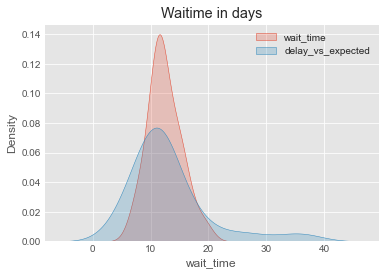

In [304]:
sns.kdeplot(delivered_orders['wait_time'], fill = True)
sns.kdeplot(delivered_orders['delay_vs_expected'], fill = True)
plt.title("Waitime in days")
plt.legend(['wait_time', 'delay_vs_expected'])
plt.show()

In [306]:
import sweetviz as sv 
sv.config_parser.read("Override.ini")

['Override.ini']

In [312]:
delivered_orders['delay_vs_expected'] 

order_purchase_timestamp
2016-10-31    35.675472
2017-01-31    26.408000
2017-02-28    18.195402
2017-03-31    11.327180
2017-04-30    11.971776
2017-05-31    12.497884
2017-06-30    11.644338
2017-07-31    11.470816
2017-08-31    12.097544
2017-09-30    10.348193
2017-10-31    10.923403
2017-11-30     7.123491
2017-12-31    12.008525
2018-01-31    11.934361
2018-02-28     7.290770
2018-03-31     5.427674
2018-04-30    11.895116
2018-05-31    11.190991
2018-06-30    18.244094
2018-07-31    10.441520
2018-08-31     7.162179
Name: delay_vs_expected, dtype: float64

In [315]:
import pandas_profiling

profile = delivered_orders.profile_report(title="Delivered order wait time")
profile.to_file(output_file="data/reports/delivered_wait.html")

import IPython
IPython.display.HTML(filename = 'data/reports/delivered_wait.html')

Number of variables,3
Number of observations,21
Missing cells,0
Missing cells (%),0.0%
Duplicate rows,0
Duplicate rows (%),0.0%
Total size in memory,632.0 B
Average record size in memory,30.1 B
NUM,2
DATE,1
order_purchase_timestamp has unique values,Unique
